In [1]:
!pip install category_encoders

In [2]:
# Визуализация и работа с данными
import pandas as pd                     # Для работы с табличными данными (DataFrame)
import numpy as np                      # Для математических операций и работы с массивами

# Подготовка данных
from sklearn.model_selection import train_test_split     # Разделение данных на обучающую и тестовую выборки
from sklearn.impute import SimpleImputer                 # Простое заполнение пропущенных значений (среднее, медиана и т.д.)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# OneHotEncoder — кодирование категориальных переменных в бинарные признаки
# StandardScaler — стандартизация числовых признаков (приведение к одному масштабу)

from sklearn.experimental import enable_iterative_imputer  # Необходим для активации IterativeImputer
from sklearn.impute import IterativeImputer                # Продвинутая итеративная иммутация пропущенных значений (на основе регрессий)

import category_encoders as ce          # Дополнительные методы кодирования категориальных признаков (Target Encoding, Ordinal и др.)

# Обучение моделей
from sklearn.linear_model import LinearRegression          # Линейная регрессия (регрессионная модель)
from sklearn.linear_model import LogisticRegression        # Логистическая регрессия (модель классификации)

# Оценка моделей
from sklearn.metrics import roc_curve, roc_auc_score       # Метрики для оценки бинарной классификации: ROC-кривая и AUC

# Визуализация результатов
import matplotlib.pyplot as plt        # Основной инструмент для построения графиков и визуализации данных
import seaborn as sns                  # Повторный импорт (можно удалить, если уже импортировано выше)


# 1. Загрузка и базовая очистка данных

In [3]:
# 1. Загрузка и базовая очистка данных
!gdown 1kHhsDnBzjOjdk7PLECLfFAPGJeAfip7V
try:
  df = pd.read_csv('/content/titanic.csv').drop(columns='Unnamed: 0')
except:
  df = pd.read_csv('titanic.csv')


Downloading...
From: https://drive.google.com/uc?id=1kHhsDnBzjOjdk7PLECLfFAPGJeAfip7V
To: /Users/antontravkin/Sites/python_rtk/part 2/Lesson 20/titanic.csv
100%|███████████████████████████████████████| 33.6k/33.6k [00:00<00:00, 183kB/s]


In [4]:
df.head()

,survived,sex,age,sibsp,fare,class,embark_town
0,0,male,22.0,1,7.2500,Third,Southampton
1,1,female,38.0,1,71.2833,First,Cherbourg
2,1,female,26.0,0,7.9250,Third,Southampton
3,1,female,35.0,1,53.1000,First,Southampton
4,0,male,35.0,0,8.0500,Third,Southampton


# 2. Деление на train и test

In [5]:
# 2. Деление на train и test
X = df.drop(columns=['survived'])
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [6]:
# роли переменных
num_cols = list(X_train.select_dtypes(include=['float', 'int']).columns)
cat_cols = list(X_train.select_dtypes(exclude=['float', 'int']).columns)
num_cols, cat_cols

(['age', 'sibsp', 'fare'], ['sex', 'class', 'embark_town'])

# 3. Поиск и анализ выбросов

In [7]:
# 3. Поиск выбросов с помощью IQR (не удаляем, только помечаем)

Q1 = X_train[num_cols].quantile(0.25)
Q3 = X_train[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Создаём DataFrame с флагами выбросов (True/False)
outlier_flags_train = ((X_train[num_cols] < (Q1 - 1.5 * IQR)) |
                       (X_train[num_cols] > (Q3 + 1.5 * IQR)))

# Пример: вывести % выбросов по колонкам
outlier_percent = outlier_flags_train.mean().sort_values(ascending=False)
print("Процент выбросов по признакам:")
outlier_percent

Процент выбросов по признакам:


fare     0.127809
sibsp    0.046348
age      0.008427
dtype: float64

In [8]:
X_train[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
age,575.0,29.807687,14.485211,0.42,21.0000,28.5000,39.0,80.0000
sibsp,712.0,0.492978,1.060720,0.00,0.0000,0.0000,1.0,8.0000
fare,712.0,31.819826,48.059104,0.00,7.8958,14.4542,31.0,512.3292


>почему fare равен 0? может дети были бесплатно? Проверим зависимость fare от age

In [9]:
X_train[X_train['fare'] == 0]['age'].min(), X_train[X_train['fare'] == 0]['age'].max()

(19.0, 49.0)

> то есть нет зависимости нулевой стоимости билета от возраста. Возможно это безбилетники, а возможно до нас просто не дошли данные, сейчас уже исправить можно только одним способом: заменяем fare=0 на np.nan

In [10]:
# обработка выбросов
X_train.loc[X_train['fare'] == 0, 'fare'] = np.nan

# на тест просто перенесем логику, которую разработали на трейне
X_test.loc[X_test['fare'] == 0, 'fare'] = np.nan

> по переменной sibsp и age значения стандартные, ничего с ними не будем делать

# 4. Анализ и обработка пропусков

In [11]:
X_train.isna().mean().sort_values()

sex            0.000000
sibsp          0.000000
class          0.000000
embark_town    0.002809
fare           0.019663
age            0.192416
dtype: float64

> - непрерывные переменные age и fare имеют пропуски. fare заполним медианой  в зависимости от embark_town. age имеет 19% пропусков, что много, попробуем восстановить с помощью модели на основании признаков: sibsp, fare
> - порт посадки embark_town также имеет пропуски, всего 2 значения. Заполним модой

In [12]:
value_embark_town = X_train.groupby('embark_town')['fare'].median()
value_embark_town

embark_town
Cherbourg      30.00
Queenstown      7.75
Southampton    13.00
Name: fare, dtype: float64

In [13]:
# Заполняем пропуски в fare, подтягивая значение по embark_town
X_train['fare_no_nan'] = (
    X_train['fare']
    .fillna( X_train['embark_town'].map(value_embark_town) )
)

In [14]:
X_train[X_train['fare'].isna()][['fare_no_nan', 'fare']]

,fare_no_nan,fare
481,13.0,NaN
302,13.0,NaN
732,13.0,NaN
179,13.0,NaN
633,13.0,NaN
466,13.0,NaN
674,13.0,NaN
597,13.0,NaN
815,13.0,NaN
413,13.0,NaN


> замена прошла,  пропуски только для строк, где embark_town = Southampton

In [15]:
# Заполняем пропуски в fare в тестовой выборке, подтягивая значение по embark_town,
# которые были расчитаны на тренировочной выборке (value_embark_town)
X_test['fare_no_nan'] = (
    X_test['fare']
    .fillna( X_test['embark_town'].map(value_embark_town) )
)

In [16]:
# Создаём и обучаем импуктер
imp = IterativeImputer(estimator=LinearRegression(), random_state=42)
df_age_imputed_train = imp.fit_transform(X_train[['age', 'sibsp', 'fare_no_nan']])

In [17]:
# Возвращаем age обратно в X_train
X_train['age_no_nan'] = df_age_imputed_train[:, 0]

In [18]:
df_age_imputed_test = imp.transform(X_test[['age', 'sibsp', 'fare_no_nan']])
# Возвращаем age обратно в X_test
X_test['age_no_nan'] = df_age_imputed_test[:, 0]

In [19]:
X_train[X_train['age'].isna()][['age_no_nan', 'age', 'sibsp', 'fare_no_nan']]

,age_no_nan,age,sibsp,fare_no_nan
692,33.247055,NaN,0,56.4958
481,31.505469,NaN,0,13.0000
527,39.865055,NaN,0,221.7792
557,40.095119,NaN,0,227.5250
828,31.295257,NaN,0,7.7500
...,...,...,...,...
277,31.505469,NaN,0,13.0000
451,26.515259,NaN,1,19.9667
680,31.310773,NaN,0,8.1375
359,31.300430,NaN,0,7.8792


In [20]:
num_cols

['age', 'sibsp', 'fare']

In [21]:
num_cols.remove('age')
num_cols.remove('fare')
num_cols.extend(['age_no_nan', 'fare_no_nan'])
num_cols

['sibsp', 'age_no_nan', 'fare_no_nan']

In [22]:
# категориальные — мода
cat_imputer = SimpleImputer(strategy='most_frequent')
# считаемм моду на трейне
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])

# на тесте мы заполняем той модой, что посчитали на трейне
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])


In [23]:
X_test = X_test[num_cols+cat_cols]
X_train = X_train[num_cols+cat_cols]

# 5. Анализ и обработка категориальных переменных

In [24]:
cat_cols_ohe = ['sex', ]
cat_cols_meant = ['class', ]
cat_cols_freq = ['embark_town', ]

handle_unknown='ignore'
- Что делает: если во время transform() (например, на X_test) встречается категория, которой не было в fit(), она не вызывает ошибку, а просто кодирует её как вектор из нулей.

- Если не указать этот параметр (по умолчанию error), при появлении новой категории будет ValueError.

sparse_output=False
- Что делает: указывает, что результат должен быть обычным numpy.ndarray, а не разреженной матрицей (scipy.sparse).

- По умолчанию OneHotEncoder возвращает разреженную матрицу, потому что большинство значений — нули (эффективнее по памяти). Но часто, особенно в pandas, нужно работать с полной таблицей.

In [25]:
# OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
X_train_encoded = encoder.fit_transform(X_train[cat_cols_ohe])
X_test_encoded = encoder.transform(X_test[cat_cols_ohe])


In [26]:
# Получаем названия новых колонок
encoded_col_names = encoder.get_feature_names_out(cat_cols_ohe)
encoded_col_names

array(['sex_male'], dtype=object)

In [27]:
# Преобразуем в DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_col_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_col_names, index=X_test.index)


In [28]:
print(X_train_encoded.shape)
print(encoded_col_names)


(712, 1)
['sex_male']


In [29]:
X_train_encoded_df.head()

,sex_male
692,1.0
481,1.0
527,1.0
855,0.0
801,0.0


In [30]:
# Удаляем старые категориальные, добавляем закодированные
X_train = X_train.drop(columns=cat_cols_ohe).join(X_train_encoded_df)
X_test = X_test.drop(columns=cat_cols_ohe).join(X_test_encoded_df)

In [31]:
X_train

,sibsp,age_no_nan,fare_no_nan,class,embark_town,sex_male
692,0,33.247055,56.4958,Third,Southampton,1.0
481,0,31.505469,13.0000,Second,Southampton,1.0
527,0,39.865055,221.7792,First,Southampton,1.0
855,0,18.000000,9.3500,Third,Southampton,0.0
801,1,31.000000,26.2500,Second,Southampton,0.0
...,...,...,...,...,...,...
359,0,31.300430,7.8792,Third,Queenstown,0.0
258,0,35.000000,512.3292,First,Cherbourg,0.0
736,1,48.000000,34.3750,Third,Southampton,0.0
462,0,47.000000,38.5000,First,Southampton,1.0


In [32]:
X_test

,sibsp,age_no_nan,fare_no_nan,class,embark_town,sex_male
565,2,24.000000,24.1500,Third,Southampton,1.0
160,0,44.000000,16.1000,Third,Southampton,1.0
553,0,22.000000,7.2250,Third,Cherbourg,1.0
860,2,41.000000,14.1083,Third,Southampton,1.0
241,1,26.336411,15.5000,Third,Queenstown,0.0
...,...,...,...,...,...,...
880,0,25.000000,26.0000,Second,Southampton,0.0
91,0,20.000000,7.8542,Third,Southampton,1.0
883,0,28.000000,10.5000,Second,Southampton,1.0
473,0,23.000000,13.7917,Second,Cherbourg,0.0


In [33]:
# Создаем TargetEncoder для нескольких колонок
target_encoder = ce.TargetEncoder(cols=cat_cols_meant)

# Обучаем энкодер и трансформируем тренировочный набор (обрати внимание, передаем сразу весь DataFrame с этими колонками)
X_train_encoded = target_encoder.fit_transform(X_train[cat_cols_meant], y_train)

# Применяем к тестовому набору
X_test_encoded = target_encoder.transform(X_test[cat_cols_meant])

# присоединить обратно к основным данным
for col in cat_cols_meant:
    X_train[col + '_target'] = X_train_encoded[col]
    X_train.drop(columns=col, inplace=True)
    X_test[col + '_target'] = X_test_encoded[col]
    X_test.drop(columns=col, inplace=True)


In [34]:
X_train

,sibsp,age_no_nan,fare_no_nan,embark_town,sex_male,class_target
692,0,33.247055,56.4958,Southampton,1.0,0.242967
481,0,31.505469,13.0000,Southampton,1.0,0.446667
527,0,39.865055,221.7792,Southampton,1.0,0.649123
855,0,18.000000,9.3500,Southampton,0.0,0.242967
801,1,31.000000,26.2500,Southampton,0.0,0.446667
...,...,...,...,...,...,...
359,0,31.300430,7.8792,Queenstown,0.0,0.242967
258,0,35.000000,512.3292,Cherbourg,0.0,0.649123
736,1,48.000000,34.3750,Southampton,0.0,0.242967
462,0,47.000000,38.5000,Southampton,1.0,0.649123


In [35]:
# Создаем CountEncoder с normalize=True
freq_encoder = ce.CountEncoder(cols=cat_cols_freq, normalize=True)

# Обучаем и трансформируем тренировочные данные (с нужными колонками)
X_train_encoded = freq_encoder.fit_transform(X_train[cat_cols_freq])

# Трансформируем тестовые данные
X_test_encoded = freq_encoder.transform(X_test[cat_cols_freq])

# Добавляем закодированные колонки в исходные датасеты с суффиксом '_freq'
for col in cat_cols_freq:
    X_train[col + '_freq'] = X_train_encoded[col]
    X_train.drop(columns=col, inplace=True)
    X_test[col + '_freq'] = X_test_encoded[col]
    X_test.drop(columns=col, inplace=True)


In [36]:
X_test

,sibsp,age_no_nan,fare_no_nan,sex_male,class_target,embark_town_freq
565,2,24.000000,24.1500,1.0,0.242967,0.727528
160,0,44.000000,16.1000,1.0,0.242967,0.727528
553,0,22.000000,7.2250,1.0,0.242967,0.195225
860,2,41.000000,14.1083,1.0,0.242967,0.727528
241,1,26.336411,15.5000,0.0,0.242967,0.077247
...,...,...,...,...,...,...
880,0,25.000000,26.0000,0.0,0.446667,0.727528
91,0,20.000000,7.8542,1.0,0.242967,0.727528
883,0,28.000000,10.5000,1.0,0.446667,0.727528
473,0,23.000000,13.7917,0.0,0.446667,0.195225


In [37]:
X_train

,sibsp,age_no_nan,fare_no_nan,sex_male,class_target,embark_town_freq
692,0,33.247055,56.4958,1.0,0.242967,0.727528
481,0,31.505469,13.0000,1.0,0.446667,0.727528
527,0,39.865055,221.7792,1.0,0.649123,0.727528
855,0,18.000000,9.3500,0.0,0.242967,0.727528
801,1,31.000000,26.2500,0.0,0.446667,0.727528
...,...,...,...,...,...,...
359,0,31.300430,7.8792,0.0,0.242967,0.077247
258,0,35.000000,512.3292,0.0,0.649123,0.195225
736,1,48.000000,34.3750,0.0,0.242967,0.727528
462,0,47.000000,38.5000,1.0,0.649123,0.727528


y = 2*age+3*income - сколько денег клиент пртратит (1000, 10000)

age = [0;100]
income = [1000, 1000000]

age_norm = mean = 0, std = 1

income_norm = mean = 0, std = 1

y = w_1 * age_norm + w_2 * income_norm + w_0


# 6. Масштабирование числовых признаков

In [38]:
num_cols_for_scaler = num_cols.copy()
num_cols_for_scaler.remove('sibsp')
num_cols_for_scaler

['age_no_nan', 'fare_no_nan']

In [39]:
scaler = StandardScaler()
X_train[num_cols_for_scaler] = scaler.fit_transform(X_train[num_cols_for_scaler])
X_test[num_cols_for_scaler] = scaler.transform(X_test[num_cols_for_scaler])

In [40]:
print("\nОбработка завершена. Размерности после кодирования:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")


Обработка завершена. Размерности после кодирования:
X_train: (712, 6), X_test: (179, 6)


In [41]:
X_train.head()

,sibsp,age_no_nan,fare_no_nan,sex_male,class_target,embark_town_freq
692,0,0.265368,0.509929,1.0,0.242967,0.727528
481,0,0.136106,-0.398320,1.0,0.446667,0.727528
527,0,0.756564,3.961264,1.0,0.649123,0.727528
855,0,-0.866285,-0.474537,0.0,0.242967,0.727528
801,1,0.098589,-0.121643,0.0,0.446667,0.727528


In [42]:
X_test.head()

,sibsp,age_no_nan,fare_no_nan,sex_male,class_target,embark_town_freq
565,2,-0.420958,-0.165494,1.0,0.242967,0.727528
160,0,1.063464,-0.333588,1.0,0.242967,0.727528
553,0,-0.569401,-0.518910,1.0,0.242967,0.195225
860,2,0.840801,-0.375178,1.0,0.242967,0.727528
241,1,-0.247547,-0.346117,0.0,0.242967,0.077247


# 7. Моделирование и Оценка модели

In [43]:
# Обучение логистической регрессии
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [44]:
# Получение вероятностей
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

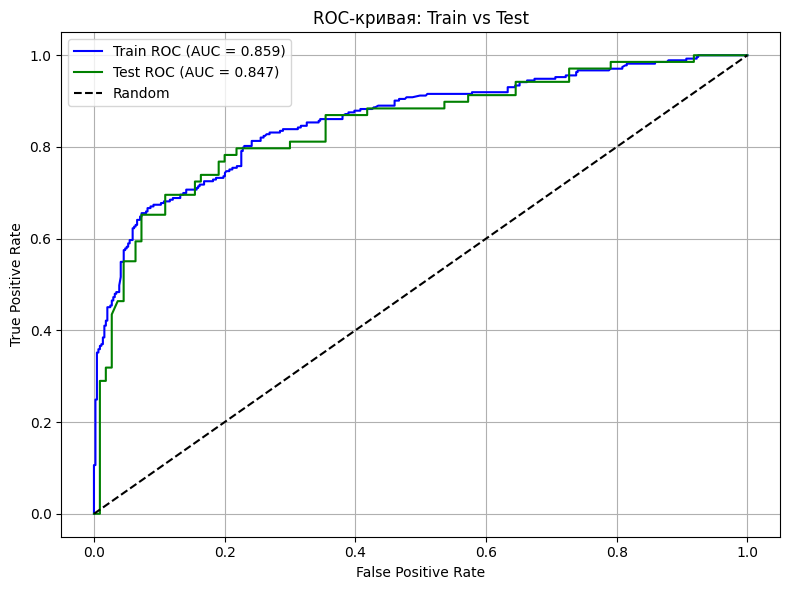

In [45]:
# ROC-кривая + AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# Построение ROC-графика
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.3f})", color="blue")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.3f})", color="green")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая: Train vs Test")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

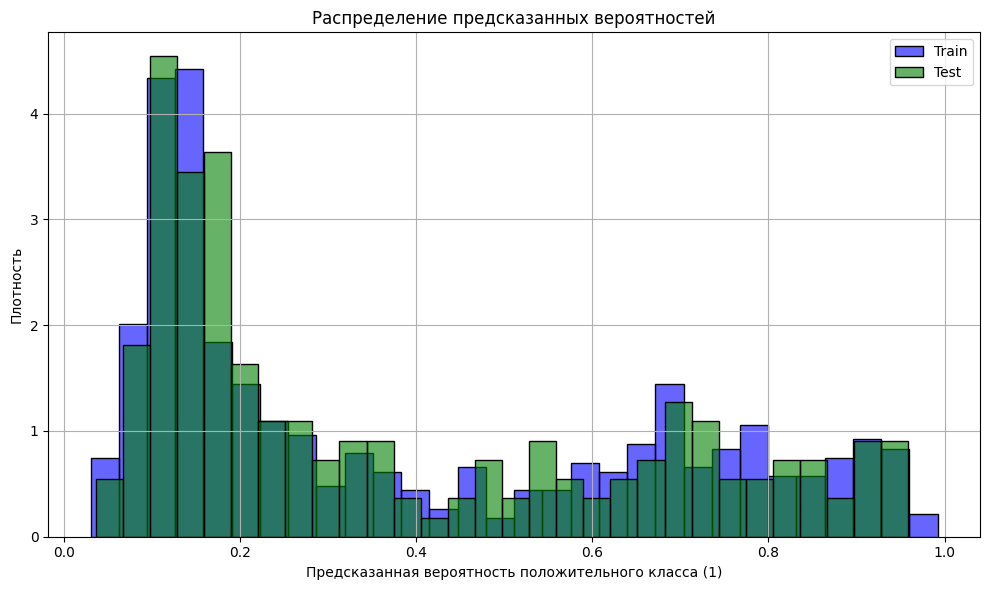

In [46]:
# Распределение вероятностей
plt.figure(figsize=(10, 6))
sns.histplot(y_train_proba, bins=30, kde=False, color='blue', label='Train', stat='density', alpha=0.6)
sns.histplot(y_test_proba, bins=30, kde=False, color='green', label='Test', stat='density', alpha=0.6)
plt.xlabel("Предсказанная вероятность положительного класса (1)")
plt.ylabel("Плотность")
plt.title("Распределение предсказанных вероятностей")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()